# 数据读入模块

In [46]:
import pandas as pd

train_data = pd.read_csv("data\main\df_train_b1.csv", index_col=0)
test_data = pd.read_csv('data\main\df_test_b1.csv', index_col=0)


## 要读入除了main之外的数在此处添加

In [47]:
import os
filenames = ["data\detail\df_basic_b1.csv",
             "data\detail\df_corp_b1.csv",
             "data\detail\df_judicial_b1.csv",
             "data\detail\df_loan2_b1.csv",
             "data\detail\df_query_b1.csv"]
for filename in filenames:
    temp = pd.read_csv(filename)
    train_data = pd.merge(train_data, temp, on="cust_id",
                          how="left", suffixes=("", "_y"))
    test_data = pd.merge(test_data, temp, on="cust_id",
                         how="left", suffixes=("", "_y"))


## 处理NAN

In [48]:
def delnan(df):
    df=df.dropna(how="all",axis=1)#删除全是空值的列
    df=df.fillna(-99)
    return df

In [49]:
df_train = delnan(train_data)
df_test = delnan(test_data)

In [50]:
""" for i in range(2, 17):
    print(df_train.iloc[:, i].value_counts()) """

' for i in range(2, 17):\n    print(df_train.iloc[:, i].value_counts()) '

## 转化为one-hot编码

In [51]:
type_col = ["basic_1",
            "basic_10",
            "basic_12",
            "basic_14"]

In [52]:
def to_one_hot(df,colnames):
    df=pd.get_dummies(df,columns=colnames)
    return df

df_train=to_one_hot(df_train,type_col)
df_test=to_one_hot(df_test,type_col)

In [53]:
full_col_name = list(df_train.columns)
basic_col = [i for i in full_col_name if "basic" in i]
loan_col = [i for i in full_col_name if "loan" in i]
overdue_col = [i for i in full_col_name if "overdue" in i]
query_col = [i for i in full_col_name if "query" in i]

x_col = basic_col+loan_col+overdue_col+query_col
# x_col为模型读入的自变量列名称


In [54]:
for i in x_col:
    if i not in df_test.columns:
        df_test[i]=0

In [55]:
# df_train.drop(columns=drop_col)

# 训练模型

## 划分测试集训练集

In [56]:
df_test[x_col]

,basic_2,basic_3,basic_4,basic_5,basic_6,basic_7,basic_8,basic_9,basic_11,basic_13,...,query_8,query_9,query_10,query_11,query_1_y,query_2_y,query_3_y,query_4_y,query_5_y,query_6_y
0,-99,-99.0,-99.0,1,1,53,0,0,0,-99,...,0,0,2,0,53.0,8.0,0.0,0.0,0.0,0.0
1,-99,-99.0,-99.0,1,1,28,0,0,0,-99,...,-99,-99,-99,-99,-99.0,-99.0,0.0,0.0,0.0,0.0
2,-99,-99.0,-99.0,2,2,36,0,0,0,-99,...,0,0,3,0,53.0,8.0,0.0,0.0,0.0,0.0
3,-99,-99.0,-99.0,2,2,35,0,0,0,-99,...,0,0,8,1,51.0,2.0,2.0,0.0,2.0,0.0
4,-99,-99.0,-99.0,1,1,46,0,0,0,-99,...,0,0,5,0,11.0,2.0,1.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6996,-99,-99.0,-99.0,2,2,34,0,0,0,-99,...,2,0,1,2,53.0,8.0,0.0,0.0,0.0,0.0
6997,111,886.0,886.0,1,1,44,0,0,0,3,...,0,0,1,0,11.0,2.0,1.0,0.0,1.0,0.0
6998,-99,-99.0,-99.0,1,1,25,0,0,0,-99,...,0,0,1,0,53.0,8.0,0.0,0.0,0.0,0.0
6999,-99,-99.0,-99.0,1,1,54,0,0,0,-99,...,0,0,7,0,24.0,2.0,2.0,0.0,2.0,0.0


In [57]:
from sklearn import model_selection


X = df_train[x_col]
Y = df_train["label"]
seed = 666
test_size = 0.1
X_train, X_test, y_train, y_test = model_selection.train_test_split(
    X, Y, test_size=test_size, random_state=seed)


## 训练模型

## 超参数

In [58]:
N = 50
num_round = 300

max_depth = [3, 4, 5]
eta = [0.1]
colsample_bytree = [0.75, 0.7, 0.65]
scale_pos_weight = [1, 2, 3, 4, 5, 6, 7]


In [59]:
import copy
import xgboost as xgb
import random


x_perd = xgb.DMatrix(df_test[x_col])
dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)
evallist = [(dtrain, 'train'), (dtest, 'eval')]

pred_labels = []
test_labels = []
loss_seq = []
max_auc_loss=0

for i in range(N):
    param = {
        'max_depth': random.choice(max_depth),
        'eta': random.choice(eta),
        'colsample_bytree': random.choice(colsample_bytree),
        'objective': 'binary:logistic',
        # 'verbosity':0,
        'scale_pos_weight': random.choice(scale_pos_weight),
        'eval_metric': 'auc',
        'seed': 666,
    }

    bst = xgb.train(param, dtrain, num_round, evallist,
                    early_stopping_rounds=10, verbose_eval=False)
    loss = float(bst.eval(dtest).split(":")[1])
    pred_label = list(bst.predict(x_perd))
    test_label = list(bst.predict(xgb.DMatrix(X_test)))

    loss_seq.append(loss)

    if loss>max_auc_loss:
        best_bst=copy.deepcopy(bst)
        max_auc_loss=loss

    print(i+1, ":", loss, sep="")
    print(param)
    print("-------------------------")
    pred_labels.append([i for i in pred_label])
    test_labels.append([i for i in test_label])


print('最大AUC:', max(loss_seq), sep="")


C:\Users\tassadar667\AppData\Roaming\Python\Python39\site-packages\xgboost\core.py:568: FutureWarning: Pass `evals` as keyword args.  Passing these as positional arguments will be considered as error in future releases.
  warnings.warn(


1:0.6992928468020342
{'max_depth': 5, 'eta': 0.1, 'colsample_bytree': 0.7, 'objective': 'binary:logistic', 'scale_pos_weight': 2, 'eval_metric': 'auc', 'seed': 666}
-------------------------
2:0.656993578083819
{'max_depth': 4, 'eta': 0.1, 'colsample_bytree': 0.75, 'objective': 'binary:logistic', 'scale_pos_weight': 4, 'eval_metric': 'auc', 'seed': 666}
-------------------------
3:0.7058678867070047
{'max_depth': 3, 'eta': 0.1, 'colsample_bytree': 0.75, 'objective': 'binary:logistic', 'scale_pos_weight': 7, 'eval_metric': 'auc', 'seed': 666}
-------------------------
4:0.6827694049519284
{'max_depth': 4, 'eta': 0.1, 'colsample_bytree': 0.65, 'objective': 'binary:logistic', 'scale_pos_weight': 7, 'eval_metric': 'auc', 'seed': 666}
-------------------------
5:0.6728070826682505
{'max_depth': 4, 'eta': 0.1, 'colsample_bytree': 0.75, 'objective': 'binary:logistic', 'scale_pos_weight': 7, 'eval_metric': 'auc', 'seed': 666}
-------------------------
6:0.6951538661420246
{'max_depth': 4, 'eta

<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

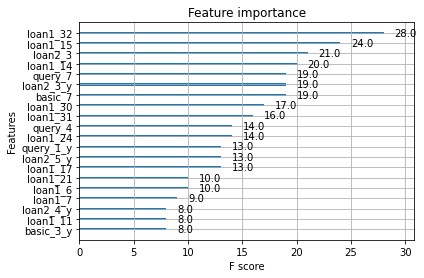

In [60]:
xgb.plot_importance(best_bst,max_num_features=20)

# 输出模块

In [61]:
import time
import numpy as np
from sklearn.metrics import roc_auc_score

date = time.strftime("%Y%m%d-%H%M%S", time.localtime())
res_num = np.argsort([-i for i in loss_seq])

# 选择前n个结果进行平均（手动指定or在本地测试集排序选出）
if True:
    max_auc = -1
    for i in range(1, N):
        temp = np.mean([test_labels[i] for i in res_num[0:i]], axis=0)
        temp_auc = roc_auc_score(y_test, temp)
        #print(temp_auc)
        if temp_auc > max_auc:
            max_auc = temp_auc
            n = i
else:
    n = 30

res_num = res_num[0:n]

final_pred_label = np.mean([pred_labels[i] for i in res_num], axis=0)
#local_auc = roc_auc_score(y_test, final_pred_label)
print("本地测试集前", n, "个auc为", [loss_seq[i] for i in res_num], sep="")
print("平均之后最大AUC为",max_auc,sep="")

res = pd.DataFrame({
    'cust_id': list(df_test["cust_id"]),
    'label': final_pred_label,
})
res.to_csv("./output/result"+date+".csv", encoding="utf-8", index=False)


本地测试集前5个auc为[0.7176769739040053, 0.7176769739040053, 0.7173892869074576, 0.7173892869074576, 0.715440439511489]
平均之后最大AUC为0.7219365974980512


# 一些tips

* 提升n有一定提升(如何确定n？)